In [28]:
import os
import sys
import random
import numpy as np
import pandas as pd
import cv2
from imutils import paths
import matplotlib.pyplot as plt
%matplotlib inline


Lets start by analyzing the number of images in each class for the training set

In [29]:
pneumonia_train = list(paths.list_images("chest_xray/train/PNEUMONIA/"))
normal_train = list(paths.list_images("chest_xray/train/NORMAL/"))
print(len(pneumonia_train))
print(len(normal_train))

3875
1341


Let's go into each class and randomly display some images to get an idea of how they look. But first lets make a function to do this for us.

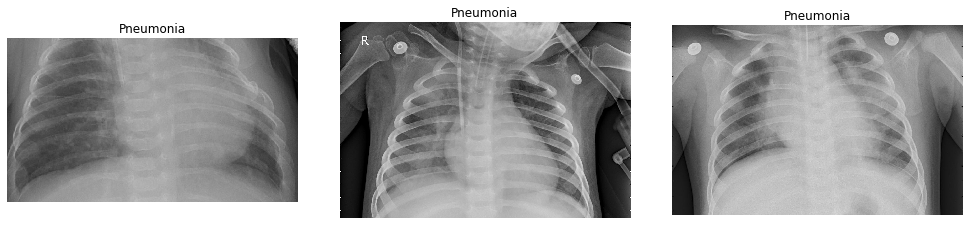

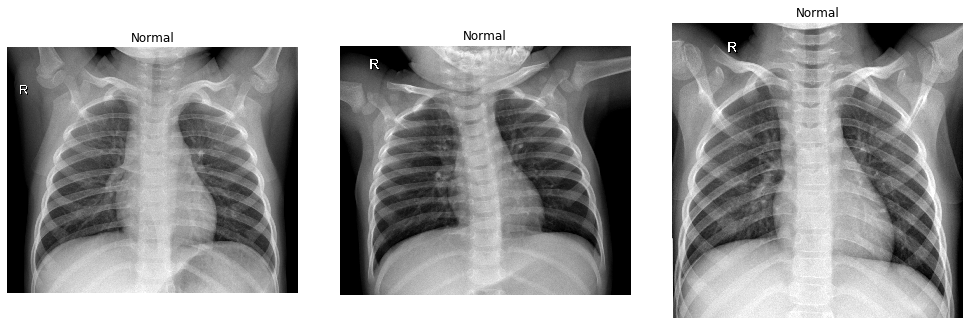

In [156]:
# function to read images
def read_image(im_path, rgb=True):
    im = cv2.imread(im_path)
    if rgb:
        return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im

# define classes
columns = 3
classes = {
    "Pneumonia":[read_image(img) for img in random.sample(pneumonia_train, columns)], 
    "Normal": [read_image(img) for img in random.sample(normal_train, columns)]
}
# this method displays images for two classes based adjacent to each other
def display(classes, columns, read_as_rgb=True):
    for _class in classes:
        #print(random_images)
        fig, axes = plt.subplots(nrows=1, ncols=columns, figsize=(14, 10), squeeze=False)
        fig.tight_layout()
        for l in range(1):
            for m, img in enumerate(classes[_class]):
                axes[l][m].imshow(img)
                axes[l][m].axis("off")
                axes[l][m].set_title(_class)
    # done displaying
    
# display images
display(classes, columns)

Let us do some preprocessing that will bring up the contrast in the images. The approach is,

-> RGB -> HSV -> H, S, V -> H, S, HistogramEqulize(V) -> HSV -> RGB

In [157]:
def preprocess(image):
    # BGR to HSV
    img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # split to H,S,V
    H, S, V = cv2.split(img)
    # histogram equalize
    V = cv2.equalizeHist(V)
    # join back
    img = cv2.merge([H, S, V])
    # HSV to RGB
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    
    return img

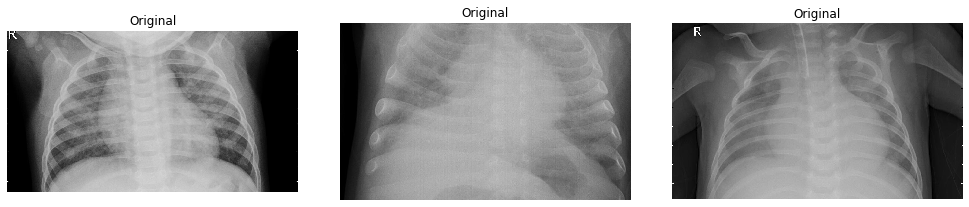

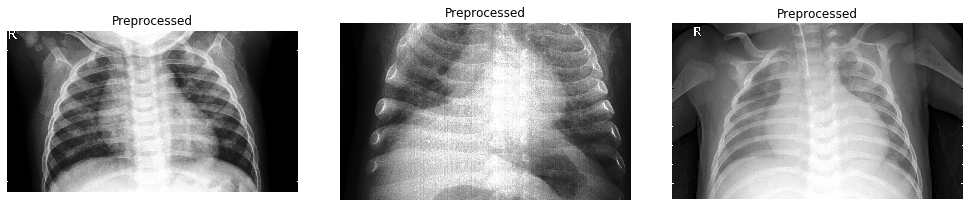

In [159]:
# get some random positive images
sample_positive = random.sample(pneumonia_train, 3)

# make a dictionary regular samples and preprocessed ones
classes = {
    "Original": [read_image(img) for img in sample_positive],
    "Preprocessed": [preprocess(read_image(img, rgb=False)) for img in sample_positive]
}

# display the images 
display(classes, 3)